In [17]:
from sqlalchemy import create_engine
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv

def create_connection():

    load_dotenv()
    host = os.environ.get('DB_DESTINATION_HOST')
    port = os.environ.get('DB_DESTINATION_PORT')
    db = os.environ.get('DB_DESTINATION_NAME')
    username = os.environ.get('DB_DESTINATION_USER')
    password = os.environ.get('DB_DESTINATION_PASSWORD')

    conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}')
    return conn

# устанавливаем соединение с базой
conn = create_connection()

In [18]:
data = pd.read_sql('select * from flats_buildings_clean', conn)
data.head()

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,130436,10,False,7.500000,19.100000,1,False,36.599998,6300000,1988,4,55.876099,37.511383,2.64,406,17,True
1,104100,13,False,14.900000,72.099998,3,False,131.300003,35200000,2009,2,55.785206,37.735790,3.00,213,17,True
2,130437,8,False,8.000000,45.000000,3,False,76.000000,16000000,2004,4,55.869358,37.527641,2.74,256,17,True
3,130438,22,False,17.799999,15.500000,1,False,42.299999,12200000,2022,2,55.835766,37.491871,2.80,264,25,True
4,130439,9,False,6.180000,29.340000,2,False,44.520000,10560000,1974,4,55.870991,37.617527,2.64,357,9,True


In [19]:
data.drop(columns=['id'], inplace=True)
data.head()

,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,10,False,7.500000,19.100000,1,False,36.599998,6300000,1988,4,55.876099,37.511383,2.64,406,17,True
1,13,False,14.900000,72.099998,3,False,131.300003,35200000,2009,2,55.785206,37.735790,3.00,213,17,True
2,8,False,8.000000,45.000000,3,False,76.000000,16000000,2004,4,55.869358,37.527641,2.74,256,17,True
3,22,False,17.799999,15.500000,1,False,42.299999,12200000,2022,2,55.835766,37.491871,2.80,264,25,True
4,9,False,6.180000,29.340000,2,False,44.520000,10560000,1974,4,55.870991,37.617527,2.64,357,9,True


In [26]:
# Разделение данных
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = data[(data['price'] > 1_000_000) & (data['price'] < 50_000_000)]

x = data.drop(columns='price')
y = data['price']

# Цена - непрерывный числовой показатель, нужно произвести бинирование - 
# разбиение цен на несколько групп с примерно одинаковым количеством объектов
# в нашем случае выделяем 10 групп и предотвращаем их повторение - duplicates='drop'
price_bins = pd.qcut(y, q=10)

x_tr, x_val, y_tr, y_val = train_test_split(
    x, y,
    test_size=0.2,
    stratify=price_bins,
    random_state=42
)

original_y_val = data.loc[x_val.index, 'price']

# Тренировочная выборка
num_features_tr = x_tr.select_dtypes(include=['float', 'int']).drop(columns=['building_type_int'])
cat_features_tr = x_tr[['building_type_int']]
binary_cat_features_tr = x_tr.select_dtypes(include='bool')

# Валидационная выборка
num_features_val = x_val.select_dtypes(include=['float', 'int']).drop(columns=['building_type_int'])
cat_features_val = x_val[['building_type_int']]
binary_cat_features_val = x_val.select_dtypes(include='bool')

binary_cols = binary_cat_features_tr.columns.tolist()
non_binary_cat_cols = cat_features_tr.columns.tolist()
num_cols = num_features_tr.columns.tolist()

# Обертка для CatBoostEncoder
class CatBoostEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = CatBoostEncoder()
        self.feature_names = None

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        return self.encoder.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

# определите список трансформаций в рамках ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), binary_cols),
        ('non_binary', CatBoostEncoderWrapper(), non_binary_cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ],
    verbose_feature_names_out=False
)

# трансформируйте исходные данные data с помощью созданного preprocessor
x_tr_transformed = preprocessor.fit_transform(x_tr, y_tr)
x_val_transformed = preprocessor.transform(x_val)


model = CatBoostRegressor(
    verbose=100,
    random_seed=42
)

# Пайплайн
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', model)
    ]
)

# Обучение пайплайна
pipeline.fit(x_tr, y_tr)

# Предсказания
y_pred = pipeline.predict(x_val)


print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared=False)) 
print('R²:', r2_score(y_val, y_pred))

# MAE: 38827.08915154271
# RMSE: 97818.44800851807
# R²: 0.9998350659848153


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ve

Learning rate set to 0.085723
0:	learn: 6988991.4661327	total: 21.9ms	remaining: 21.8s
100:	learn: 137461.1855755	total: 1.8s	remaining: 16s
200:	learn: 115889.6197206	total: 3.62s	remaining: 14.4s
300:	learn: 105373.8630563	total: 5.41s	remaining: 12.6s
400:	learn: 98751.5791383	total: 7.2s	remaining: 10.7s
500:	learn: 93927.2669658	total: 9.04s	remaining: 9s
600:	learn: 89970.4019823	total: 10.9s	remaining: 7.22s
700:	learn: 86727.3227258	total: 14.3s	remaining: 6.11s
800:	learn: 84112.5793649	total: 18.4s	remaining: 4.58s
900:	learn: 81715.6272072	total: 22s	remaining: 2.42s
999:	learn: 79499.9817227	total: 24.4s	remaining: 0us


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE: 38827.08915154271
RMSE: 97818.44800851807
R²: 0.9998350659848153


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype

In [ ]:
# Кросс-валидация
from sklearn.model_selection import cross_val_score

neg_mae_scores = cross_val_score(
    pipeline, x, y,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

mae_scores = -neg_mae_scores
print('MAE на кросс-валидации (по фолдам):', mae_scores)
print('Средний MAE:', mae_scores.mean())
print('Стандартное отклонение:', mae_scores.std())

# MAE на кросс-валидации (по фолдам): [34880.3487744  33100.63965542 38203.81256636 42439.58160784
#  39860.29543549]
# Средний MAE: 37696.93560790356
# Стандартное отклонение: 3361.215225146131

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecat

Learning rate set to 0.085723
Learning rate set to 0.085723
0:	learn: 7066294.5587122	total: 93.2ms	remaining: 1m 33s
0:	learn: 7042447.9773824	total: 93.3ms	remaining: 1m 33s
100:	learn: 125394.2962119	total: 4.96s	remaining: 44.2s
100:	learn: 142481.3502385	total: 5.14s	remaining: 45.7s
200:	learn: 116741.4482232	total: 9.03s	remaining: 35.9s
200:	learn: 102374.9250023	total: 9.04s	remaining: 35.9s
300:	learn: 92465.3416357	total: 13.1s	remaining: 30.3s
300:	learn: 103778.7534471	total: 13.2s	remaining: 30.6s
400:	learn: 85699.6166349	total: 16.8s	remaining: 25.1s
400:	learn: 96166.0524719	total: 17.1s	remaining: 25.5s
500:	learn: 81881.3574463	total: 21.9s	remaining: 21.9s
500:	learn: 90888.9700313	total: 22.4s	remaining: 22.3s
600:	learn: 78776.5428004	total: 30s	remaining: 19.9s
600:	learn: 86612.4618837	total: 30s	remaining: 19.9s
700:	learn: 83459.2234309	total: 36.2s	remaining: 15.5s
700:	learn: 76052.7654561	total: 36.4s	remaining: 15.5s
800:	learn: 80504.1629128	total: 40.6s	

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be rem

999:	learn: 70113.5626419	total: 48.6s	remaining: 0us


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ve

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Learning rate set to 0.085723
0:	learn: 7008149.7273561	total: 59.5ms	remaining: 59.4s
Learning rate set to 0.085723
0:	learn: 6867158.7206655	total: 53.9ms	remaining: 53.9s
100:	learn: 139426.3150797	total: 7.03s	remaining: 1m 2s
100:	learn: 139036.2721891	total: 7.83s	remaining: 1m 9s
200:	learn: 116335.5095208	total: 15.5s	remaining: 1m 1s
200:	learn: 116491.0473847	total: 16.5s	remaining: 1m 5s
300:	learn: 105523.3853080	total: 22.1s	remaining: 51.4s
300:	learn: 103791.8298825	total: 22.1s	remaining: 51.3s
400:	learn: 98235.7012991	total: 26.1s	remaining: 39s
400:	learn: 95677.9227726	total: 26s	remaining: 38.8s
500:	learn: 92427.8094016	total: 30.2s	remaining: 30.1s
500:	learn: 89807.6104388	total: 30.1s	remaining: 29.9s
600:	learn: 87928.1654910	total: 34.6s	remaining: 22.9s
600:	learn: 85540.8763273	total: 34.7s	remaining: 23.1s
700:	learn: 84222.7533216	total: 39.4s	remaining: 16.8s
700:	learn: 82253.5958218	total: 39.2s	remaining: 16.7s
800:	learn: 81071.1811636	total: 44s	rem

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


999:	learn: 73793.9340084	total: 55.8s	remaining: 0us


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be rem

Learning rate set to 0.085723
0:	learn: 6952700.8141825	total: 17.9ms	remaining: 17.9s
100:	learn: 131124.5402935	total: 1.75s	remaining: 15.5s
200:	learn: 109420.2951564	total: 3.88s	remaining: 15.4s
300:	learn: 98252.7225252	total: 6.09s	remaining: 14.2s
400:	learn: 91875.6272964	total: 8.37s	remaining: 12.5s
500:	learn: 86965.2592507	total: 10.6s	remaining: 10.5s
600:	learn: 83095.9950252	total: 12.5s	remaining: 8.3s
700:	learn: 80090.5895189	total: 14.6s	remaining: 6.23s
800:	learn: 77717.4020229	total: 16.8s	remaining: 4.17s
900:	learn: 75492.0727144	total: 18.6s	remaining: 2.04s
999:	learn: 73188.0280670	total: 20.8s	remaining: 0us


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be rem

MAE на кросс-валидации (по фолдам): [34880.3487744  33100.63965542 38203.81256636 42439.58160784
 39860.29543549]
Средний MAE: 37696.93560790356
Стандартное отклонение: 3361.215225146131


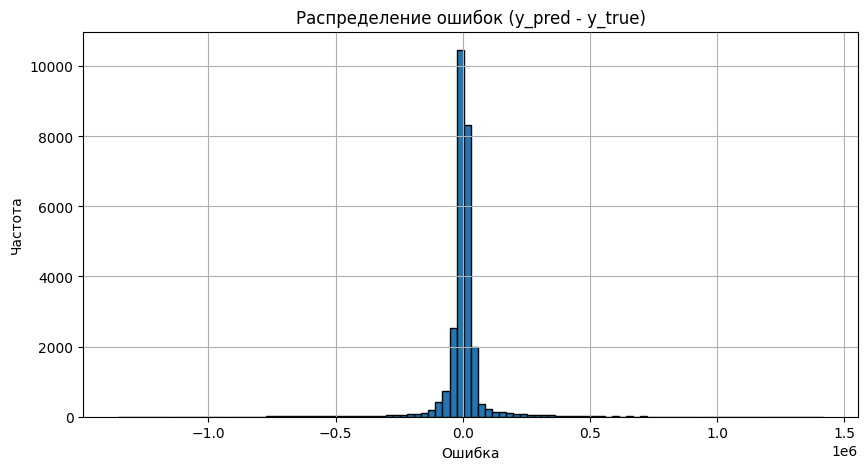

In [ ]:
# Гистограмма ошибок
import matplotlib.pyplot as plt

errors = y_pred - original_y_val

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=100, edgecolor='k')
plt.title('Распределение ошибок (y_pred - y_true)')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [ ]:
# MAE по диапазонам цен

df_val = x_val.copy()
df_val['true_price'] = original_y_val
df_val['pred_price'] = y_pred
df_val['error'] = df_val['pred_price'] - df_val['true_price']
df_val['abs_error'] = df_val['error'].abs()

# Разделим на 5 бинов по цене
df_val['price_bin'] = pd.qcut(df_val['true_price'], q=5)

# Средняя абсолютная ошибка по каждому бинe
bin_mae = df_val.groupby('price_bin')['abs_error'].mean()
print('MAE по диапазонам цен:')
print(bin_mae)

# MAE по диапазонам цен:
# price_bin
# (1489999.999, 8300000.0]     23340.602050
# (8300000.0, 10340000.0]      14716.674654
# (10340000.0, 12800000.0]     14667.359793
# (12800000.0, 17300000.0]     22178.545203
# (17300000.0, 49999000.0]    119225.281567
# Name: abs_error, dtype: float64

MAE по диапазонам цен:
price_bin
(1489999.999, 8300000.0]     23340.602050
(8300000.0, 10340000.0]      14716.674654
(10340000.0, 12800000.0]     14667.359793
(12800000.0, 17300000.0]     22178.545203
(17300000.0, 49999000.0]    119225.281567
Name: abs_error, dtype: float64


/tmp/ipykernel_5642/1748053410.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mae = df_val.groupby('price_bin')['abs_error'].mean()
